<a href="https://colab.research.google.com/github/BrovkoD/spectral-cross-attention/blob/master/spectral_cross_attention_with_ssl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, einsum
from einops import rearrange
import math
import argparse
import time
import torch.backends.cudnn as cudnn
import torch
from osgeo import gdal
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from einops import repeat
from einops.layers.torch import Rearrange
import numpy as np
import scipy.io as sio
import torch.utils.data as Data
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import nn, Tensor
import torch.nn.functional as F
from typing import Optional, Tuple, Union, Dict
from torch import Tensor
from torch.nn import functional as F
import random

# Config

In [2]:
parser = argparse.ArgumentParser("HSI")
parser.add_argument('--dataset', choices=['HanChuan', 'LongKou', 'HongHu'], default='HongHu15',
                    help='dataset to use')
# parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train and test', help='testing mark')
parser.add_argument('--model', choices=['ViT', 'CVT', 'Cvt3D'], default='MDvT', help='model choice')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='ViT', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='gpu id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--test_freq', type=int, default=5, help='number of evaluation')
parser.add_argument('--patches', type=int, default=15, help='number of patches')
parser.add_argument('--num_classes', type=int, default=22, help='number of class')
parser.add_argument('--band_patches', type=int, default=1, help='number of related band')
parser.add_argument('--epoches', type=int, default=10, help='epoch number')
# parser.add_argument('--epoches', type=int, default=30, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.9, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0, help='weight_decay')
# parser.add_argument('--classes', type=int, default=22, help='category')
# args = parser.parse_args()
args = parser.parse_args(args=[])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rndm Seed

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = True

# Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def mirror_hsi(height, width, band, input_normalize, patch=5):
    padding = patch // 2
    mirror_hsi = np.zeros((height + 2 * padding, width + 2 * padding, band), dtype=float)
    mirror_hsi[padding:(padding + height), padding:(padding + width), :] = input_normalize
    for i in range(padding):
        mirror_hsi[padding:(height + padding), i, :] = input_normalize[:, padding - i - 1, :]
    for i in range(padding):
        mirror_hsi[padding:(height + padding), width + padding + i, :] = input_normalize[:, width - 1 - i, :]
    for i in range(padding):
        mirror_hsi[i, :, :] = mirror_hsi[padding * 2 - i - 1, :, :]
    for i in range(padding):
        mirror_hsi[height + padding + i, :, :] = mirror_hsi[height + padding - 1 - i, :, :]

    print("**************************************************")
    print("patch is : {}".format(patch))
    print("mirror_image shape : [{0},{1},{2}]".format(mirror_hsi.shape[0], mirror_hsi.shape[1], mirror_hsi.shape[2]))
    print("**************************************************")
    return mirror_hsi

def gain_neighborhood_pixel(mirror_image, point, i, patch=5):
    x = point[i, 0]
    y = point[i, 1]
    temp_image = mirror_image[x:(x + patch), y:(y + patch), :]
    return temp_image


def train_and_test_data(mirror_image, band, train_point, patch=5):
    x_train = np.zeros((train_point.shape[0], patch, patch, band), dtype=float)
    with tqdm(total=train_point.shape[0], file=sys.stdout) as pbar:
        for i in range(train_point.shape[0]):
            pbar.update(1)
            x_train[i, :, :, :] = gain_neighborhood_pixel(mirror_image, train_point, i, patch)
    print("x_train shape = {}, type = {}".format(x_train.shape, x_train.dtype))
    return x_train

def train_and_test_label(number_train, num_classes):
    y_train = []
    y_test = []
    y_true = []
    for i in range(num_classes):
        for j in range(number_train[i]):
            y_train.append(i)
    y_train = np.array(y_train)
    return y_train

def pca_change(X, num_components=10):
    print(f'X.shape{X.shape}')
    newX = np.reshape(X, (-1, X.shape[2]))
    print(f'newX.shape{newX.shape}')
    pca = PCA(n_components=num_components, whiten=True)
    newX = pca.fit_transform(newX)
    print(f'newX2.shape{newX.shape}')
    newX = np.reshape(newX, (X.shape[0], X.shape[1], num_components))
    return newX

def padwithzeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def chooose_train_and_test_point(train_data, num_classes):
    number_train = []
    pos_train = {}
    # -------------------------for train data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(train_data == i + 1)
        class1 = each_class[:(each_class.shape[0]), :]
        number_train.append(class1.shape[0])
        pos_train[i] = class1
    total_pos_train = pos_train[0]
    for i in range(1, num_classes):
        total_pos_train = np.r_[total_pos_train, pos_train[i]]  # (695,2)
    total_pos_train = total_pos_train.astype(int)

    return total_pos_train, number_train

def divide_train_and_test_point(train_data, num_classes):
    number_train = []
    pos_train = {}
    train1 = []
    t1_lab = {}
    # -------------------------for train data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(train_data == i + 1)
        #  Note that Honghu 15 Hanchuan 10 Loukou 10
        class1 = each_class[:int(each_class.shape[0] / 15), :]
        train1.append(class1.shape[0])
        t1_lab[i] = class1
    total_t1_lab = t1_lab[0]
    # total_t2_lab = t2_lab[0]
    for i in range(1, num_classes):
        # total_pos_train = np.r_[total_pos_train, pos_train[i]] #(695,2)
        total_t1_lab = np.r_[total_t1_lab, t1_lab[i]]  # (695,2)
        # total_t2_lab = np.r_[total_t2_lab, t2_lab[i]] #(695,2)

    # total_pos_train = total_pos_train.astype(int)
    total_t1_lab = total_t1_lab.astype(int)
    # total_t2_lab = total_t2_lab.astype(int)

    return total_t1_lab, train1

In [7]:
url = "/content/drive/MyDrive/HongHu/" + str(args.dataset) + "_" + str(args.model) + "_epoches_" + str(
    args.epoches) + "patches_" + str(args.patches)
model_path = url + ".pt"
file_name = url + ".txt"

data_hsi = np.transpose(gdal.Open("/content/drive/MyDrive/WHU-Hi-HongHu/WHU-Hi-HongHu.tif").ReadAsArray(),
                        axes=[1, 2, 0])
data_hsi = pca_change(data_hsi, 100)
height, width, band = data_hsi.shape
train_meta = gdal.Open(
    "/content/drive/MyDrive/WHU-Hi-HongHu/Training samples and test samples/Train150.tif").ReadAsArray()
test_meta = gdal.Open(
    "/content/drive/MyDrive/WHU-Hi-HongHu/Training samples and test samples/Test150.tif").ReadAsArray()
mirror_image = padwithzeros(data_hsi, margin=int((args.patches - 1) / 2))
print("------------mirror_image={}------------".format(mirror_image.shape))
total_train, number_train = chooose_train_and_test_point(train_meta, num_classes=args.num_classes)
print(total_train.shape)
print("------------number_train={}------------".format(number_train))
# Reduce the sample size of the test set to cope with the lack of memory, you can modify it yourself
total_test, number_test = divide_train_and_test_point(test_meta, num_classes=args.num_classes)
print("------------total_test={}------------".format(total_test.shape))
print("------------number_test={}------------".format(number_test))

x_train_band = train_and_test_data(mirror_image, data_hsi.shape[2], total_train, patch=args.patches)
x_test_band = train_and_test_data(mirror_image, data_hsi.shape[2], total_test, patch=args.patches)
y_train_band = train_and_test_label(number_train, num_classes=args.num_classes)
y_test_band = train_and_test_label(number_test, num_classes=args.num_classes)
#     shape--> （batch_size, 1, height ,weight, channel）
x_train = torch.from_numpy(x_train_band).type(torch.FloatTensor).unsqueeze(1)
y_train = torch.from_numpy(y_train_band).type(torch.LongTensor)
Label_train = Data.TensorDataset(x_train, y_train)
x_test = torch.from_numpy(x_test_band).type(torch.FloatTensor).unsqueeze(1)
y_test = torch.from_numpy(y_test_band).type(torch.LongTensor)
Label_test = Data.TensorDataset(x_test, y_test)

/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


X.shape(940, 475, 270)
newX.shape(446500, 270)
newX2.shape(446500, 100)
------------mirror_image=(954, 489, 100)------------
(3300, 2)
------------number_train=[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]------------
------------total_test=(25549, 2)------------
------------number_test=[926, 224, 1444, 10875, 404, 2960, 1596, 260, 711, 816, 724, 586, 1490, 480, 56, 474, 190, 204, 570, 222, 78, 259]------------
100%|██████████| 3300/3300 [00:00<00:00, 9693.17it/s]
x_train shape = (3300, 15, 15, 100), type = float64
100%|██████████| 25549/25549 [00:02<00:00, 9742.14it/s]
x_train shape = (25549, 15, 15, 100), type = float64


# MDvT

In [36]:
class  MultiHeadAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        attn_dropout: float = 0.1,
        bias: bool = True,
        *args,
        **kwargs
    ) -> None:
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                "Embedding dim must be divisible by number of heads in {}. Got: embed_dim={} and num_heads={}".format(
                    self.__class__.__name__, embed_dim, num_heads
                )
            )

        self.qkv_proj = nn.Linear(in_features=embed_dim, out_features=3 * embed_dim, bias=bias)

        self.attn_dropout = nn.Dropout(p=attn_dropout)
        self.out_proj = nn.Linear(in_features=embed_dim, out_features=embed_dim, bias=bias)

        self.head_dim = embed_dim // num_heads
        self.scaling = self.head_dim ** -0.5
        self.softmax = nn.Softmax(dim=-1)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
    def forward(self, x_q: torch.Tensor) -> torch.Tensor:
        # [N, P, C]
        b_sz, n_patches, in_channels = x_q.shape

        # self-attention
        # [N, P, C] -> [N, P, 3C] -> [N, P, 3, h, c] where C = hc
        qkv = self.qkv_proj(x_q).reshape(b_sz, n_patches, 3, self.num_heads, -1)

        # [N, P, 3, h, c] -> [N, h, 3, P, C]
        qkv = qkv.transpose(1, 3).contiguous()

        # [N, h, 3, P, C] -> [N, h, P, C] x 3
        query, key, value = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]

        query = query * self.scaling

        # [N h, P, c] -> [N, h, c, P]
        key = key.transpose(-1, -2)

        # QK^T
        # [N, h, P, c] x [N, h, c, P] -> [N, h, P, P]
        attn = torch.matmul(query, key)
        attn = self.softmax(attn)
        attn = self.attn_dropout(attn)

        # weighted sum
        # [N, h, P, P] x [N, h, P, c] -> [N, h, P, c]
        out = torch.matmul(attn, value)

        # [N, h, P, c] -> [N, P, h, c] -> [N, P, C]
        out = out.transpose(1, 2).reshape(b_sz, n_patches, -1)
        out = self.out_proj(out)

        return out
class SepConv3d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,):
        super(SepConv3d, self).__init__()
        self.depthwise = torch.nn.Conv3d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.bn = torch.nn.BatchNorm3d(in_channels)
        self.pointwise = torch.nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.,act_layer=GELU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            act_layer,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class ConvAttention(nn.Module):
    def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False):

        super().__init__()
        self.last_stage = last_stage
        self.img_size = img_size
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv3d(dim, inner_dim, kernel_size, q_stride, pad)
        self.to_k = SepConv3d(dim, inner_dim, kernel_size, k_stride, pad)
        self.to_v = SepConv3d(dim, inner_dim, kernel_size, v_stride, pad)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        if self.last_stage:
            cls_token = x[:, 0]
            x = x[:, 1:]
            cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
        #i为光谱维度
        x = rearrange(x, 'b (l w i) n -> b n l w i', l=self.img_size, w=self.img_size)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w i-> b h (l w i) d', h=h)

        v = self.to_v(x)
        v = rearrange(v, 'b (h d) l w i-> b h (l w i) d', h=h)

        k = self.to_k(x)
        k = rearrange(k, 'b (h d) l w i-> b h (l w i) d', h=h)

        if self.last_stage:
            q = torch.cat((cls_token, q), dim=2)
            v = torch.cat((cls_token, v), dim=2)
            k = torch.cat((cls_token, k), dim=2)


        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

'''
Compared with the cvt model, replacing the convolution mapping with conv3d enhances the capture of spectral information

'''


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=0, groups=1):
        # padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm3d(out_channel),
            nn.ReLU6(inplace=True)
        )


class Transformer(nn.Module):
    # 去掉mlp_dim参数
    def __init__(self, dim, img_size, depth, heads, dim_head, channel_depth=1, dropout=0., last_stage=False,
                 mobile_block=False, mode="ViT"):
        super().__init__()
        self.layers = nn.ModuleList([])
        mlp_dim = dim * 4

        for _ in range(depth):
            if last_stage == True:
                self.layers.append(nn.ModuleList([

                    PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout,
                                               last_stage=last_stage)),
                    PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
                ]))
            else:
                self.layers.append(nn.ModuleList([

                    PreNorm(dim, MultiHeadAttention(dim, heads)),
                    PreNorm(dim, FeedForward(dim, dim * 2, dropout=dropout, act_layer=SiLU()))
                ]))
        self.mode = mode
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x


class InvertedResidual(nn.Module):
    def __init__(self, in_channel, out_channel, stride, padding, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_channel = in_channel * expand_ratio
        self.use_shortcut = stride == 1 and in_channel == out_channel

        layers = []
        if expand_ratio != 1:
            # 1x1 pointwise conv
            layers.append(ConvBNReLU(in_channel, hidden_channel, kernel_size=1))
        layers.extend([
            # 3x3 depthwise conv
            ConvBNReLU(hidden_channel, hidden_channel, stride=stride, padding=padding, groups=hidden_channel),
            # 1x1 pointwise conv(linear)=padding
            nn.Conv3d(hidden_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm3d(out_channel),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)

class SiLU(torch.nn.Module):  # export-friendly version of nn.SiLU()
    @staticmethod
    def forward(x):
        return x * torch.sigmoid(x)


class ConvLayer(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: Union[int, Tuple[int, int, int]],
            stride: Optional[Union[int, Tuple[int, int, int]]] = 1,
            groups: Optional[int] = 1,
            bias: Optional[bool] = False,
            use_norm: Optional[bool] = True,
            use_act: Optional[bool] = True,
    ) -> None:
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size, kernel_size)

        if isinstance(stride, int):
            stride = (stride, stride, stride)

        assert isinstance(kernel_size, Tuple)
        assert isinstance(stride, Tuple)

        padding = (
            int((kernel_size[0] - 1) / 2),
            int((kernel_size[1] - 1) / 2),
            int((kernel_size[1] - 1) / 2),
        )

        block = nn.Sequential()

        conv_layer = nn.Conv3d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            groups=groups,
            padding=padding,
            bias=bias
        )

        block.add_module(name="conv", module=conv_layer)

        if use_norm:
            norm_layer = nn.BatchNorm3d(num_features=out_channels, momentum=0.1)
            block.add_module(name="norm", module=norm_layer)

        if use_act:
            act_layer = SiLU()
            block.add_module(name="act", module=act_layer)

        self.block = block

    def forward(self, x: Tensor) -> Tensor:
        return self.block(x)


class MobileViTBlock(nn.Module):

    def __init__(
            self,
            in_channels: int,
            transformer_dim: int,
            img_size: int,
            channel_depth: int = 1,
            depth: int = 2,
            num_heads: int = 4,
            attn_dropout: float = 0.0,
            dropout: float = 0.1,
            ffn_dropout: float = 0.0,
            patch_h: int = 2,
            patch_w: int = 2,
            patch_d: int = 2,
            conv_ksize: Optional[int] = 3,
            last_stage: bool = False,
            mobile_block: bool = True,
            mode: str = "ViT",
            *args,
            **kwargs
    ) -> None:
        super().__init__()

        conv_3x3_in = ConvLayer(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=conv_ksize,
            stride=1
        )
        conv_1x1_in = ConvLayer(
            in_channels=in_channels,
            out_channels=transformer_dim,
            kernel_size=1,
            stride=1,
            use_norm=False,
            use_act=False
        )

        conv_1x1_out = ConvLayer(
            in_channels=transformer_dim,
            out_channels=in_channels,
            kernel_size=1,
            stride=1
        )
        conv_3x3_out = ConvLayer(
            in_channels=2 * in_channels,
            out_channels=in_channels,
            kernel_size=conv_ksize,
            stride=1
        )

        self.local_rep = nn.Sequential()
        self.local_rep.add_module(name="conv_3x3", module=conv_3x3_in)
        self.local_rep.add_module(name="conv_1x1", module=conv_1x1_in)

        global_rep = [Transformer(
            dim=transformer_dim,
            img_size=img_size,
            channel_depth=channel_depth,
            dim_head=64,
            depth=depth,
            heads=num_heads,
            dropout=dropout,
            last_stage=last_stage,
            mobile_block=mobile_block,
            mode=mode,
        )]

        global_rep.append(nn.LayerNorm(transformer_dim))
        self.global_rep = nn.Sequential(*global_rep)

        self.conv_proj = conv_1x1_out
        self.fusion = conv_3x3_out

        self.patch_h = patch_h
        self.patch_w = patch_w
        self.patch_d = patch_d
        self.patch_area = self.patch_w * self.patch_h * self.patch_d

        self.cnn_in_dim = in_channels
        self.cnn_out_dim = transformer_dim
        self.n_heads = num_heads
        self.dropout = dropout
        self.attn_dropout = attn_dropout
        self.ffn_dropout = ffn_dropout
        self.n_blocks = depth
        self.conv_ksize = conv_ksize

    def unfolding(self, x: Tensor) -> Tuple[Tensor, Dict]:
        patch_w, patch_h, patch_d = self.patch_w, self.patch_h, self.patch_d
        patch_area = patch_w * patch_h * patch_d
        # print("----------------x={}---------------".format(x.shape))
        batch_size, in_channels, orig_h, orig_w, orig_d = x.shape

        new_h = int(math.ceil(orig_h / self.patch_h) * self.patch_h)
        new_w = int(math.ceil(orig_w / self.patch_w) * self.patch_w)
        new_d = int(math.ceil(orig_d / self.patch_d) * self.patch_d)

        interpolate = False
        if new_w != orig_w or new_h != orig_h or new_d != orig_d:
            # Note: Padding can be done, but then it needs to be handled in attention function.
            x = F.interpolate(x, size=(new_h, new_w, new_d), mode="trilinear", align_corners=False)
            interpolate = True

        # number of patches along width and height
        num_patch_w = new_w // patch_w  # n_w
        num_patch_h = new_h // patch_h  # n_h
        num_patch_d = new_d // patch_d  # n_d
        num_patches = num_patch_h * num_patch_w * num_patch_d  # N

        x = x.reshape(batch_size * patch_area, num_patches, -1)

        info_dict = {
            "orig_size": (orig_h, orig_w, orig_d),
            "batch_size": batch_size,
            "interpolate": interpolate,
            "total_patches": num_patches,
            "num_patches_w": num_patch_w,
            "num_patches_h": num_patch_h,
            "num_patches_d": num_patch_d,
        }

        return x, info_dict

    def folding(self, x: Tensor, info_dict: Dict) -> Tensor:
        n_dim = x.dim()
        assert n_dim == 3, "Tensor should be of shape BPxNxC. Got: {}".format(
            x.shape
        )
        # [BP, N, C] --> [B, P, N, C]
        x = x.contiguous().view(
            info_dict["batch_size"], self.patch_area, info_dict["total_patches"], -1
        )

        batch_size, pixels, num_patches, channels = x.size()
        num_patch_h = info_dict["num_patches_h"]
        num_patch_w = info_dict["num_patches_w"]
        num_patch_d = info_dict["num_patches_d"]
        x = x.reshape(batch_size, channels, num_patch_h * self.patch_h, num_patch_w * self.patch_w,
                      num_patch_d * self.patch_d)
        if info_dict["interpolate"]:
            x = F.interpolate(
                x,
                size=info_dict["orig_size"],
                mode="trilinear",
                align_corners=False,
            )
        return x

    def forward(self, x: Tensor) -> Tensor:
        res = x

        fm = self.local_rep(x)

        # convert feature map to patches
        patches, info_dict = self.unfolding(fm)

        # learn global representations
        for transformer_layer in self.global_rep:
            patches = transformer_layer(patches)

        # [B x Patch x Patches x C] -> [B x C x Patches x Patch]
        fm = self.folding(x=patches, info_dict=info_dict)

        fm = self.conv_proj(fm)

        fm = self.fusion(torch.cat((res, fm), dim=1))
        return fm

class MDvT(nn.Module):
    def __init__(self, image_size, channels, num_classes, dim=64, kernels=[3, 3, 3], strides=[2, 2, 2],
                 heads=[2, 4, 4], depth=[2, 4, 6], pool='cls', dropout=0.1, emb_dropout=0.1, scale_dim=4, mode="ViT"):
        super().__init__()
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim
        self.heads = heads
        ##### Stage 1 #######
        # n is spectral dimention
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=dim, kernel_size=kernels[0], stride=strides[0], padding=1),
            nn.BatchNorm3d(dim),
            nn.ReLU(inplace=True),
        )
        self.stage1_transformer = nn.Sequential(
            MobileViTBlock(in_channels=dim, transformer_dim=96, img_size=(image_size + 1) // 2,
                           channel_depth=(channels + 1) // 2,
                           depth=depth[0], num_heads=heads[0], mode=mode),
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = 2
        channels = (channels + 1) // 2
        image_size = (image_size + 1) // 2
        dim = scale * dim
        self.conv2 = nn.Sequential(
            nn.Conv3d(in_channels, dim, kernels[1], strides[1], 1),
            nn.BatchNorm3d(dim),
            nn.ReLU(inplace=True),
        )
        self.stage2_transformer = nn.Sequential(
            MobileViTBlock(in_channels=dim, transformer_dim=120, img_size=(image_size + 1) // 2,
                           channel_depth=(channels + 1) // 2, depth=depth[1], num_heads=heads[1], mode=mode),
        )

        ##### Stage 3 #######
        in_channels = dim
        # //((heads[1]//heads[0]))
        scale = 2
        channels = (channels + 1) // 2
        image_size = (image_size + 1) // 2
        dim = (scale * dim)
        self.conv3 = InvertedResidual(in_channels, dim, 2, 1, 6)
        self.stage3_conv_embed = nn.Sequential(
            Rearrange('b c h w n-> b (h w n) c', h=(image_size + 1) // 2, w=(image_size + 1) // 2),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=(image_size + 1) // 2, depth=depth[2],
                        heads=heads[2], channel_depth=(channels + 1) // 2, dim_head=self.dim,
                        dropout=dropout, last_stage=True, mode=mode),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        conv1 = self.conv1(img)
        xs_trans1 = self.stage1_transformer(conv1)

        conv2 = self.conv2(xs_trans1)
        xs_trans2 = self.stage2_transformer(conv2)

        conv3 = self.conv3(xs_trans2)
        xs_conv3 = self.stage3_conv_embed(conv3)
        b, n, _ = xs_conv3.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs_cat = torch.cat((cls_tokens, xs_conv3), dim=1)
        xs_drop = self.dropout_large(xs_cat)
        xs_trans3 = self.stage3_transformer(xs_drop)
        xs = xs_trans3.mean(dim=1) if self.pool == 'mean' else xs_trans3[:, 0]

        xs = self.mlp_head(xs)
        return xs


class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res, target, pred.squeeze()


def train_epoch(model, train_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    train_loader = tqdm(train_loader, file=sys.stdout)
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):

        batch_data = batch_data.cuda()  # (32,200,25)
        batch_target = batch_target.cuda()

        optimizer.zero_grad()
        batch_pred = model(batch_data)  # (32,16)

        loss = criterion(batch_pred, batch_target)
        loss.backward()
        optimizer.step()

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre


def output_metric(tar, pre):
    matrix = confusion_matrix(tar, pre)
    classification = classification_report(tar, pre, digits=4)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA, matrix, classification


def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=np.float64)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA


def test_epoch(model, valid_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    valid_loader = tqdm(valid_loader, file=sys.stdout)
    for batch_idx, (batch_data, batch_target) in enumerate(valid_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        batch_pred = model(batch_data)

        loss = criterion(batch_pred, batch_target)

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())

    return top1.avg, objs.avg, tar, pre

def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch * patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch * patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch * patch * band_patch, band), dtype=float)
    x_train_band[:, nn * patch * patch:(nn + 1) * patch * patch, :] = x_train_reshape
    for i in range(nn):
        if pp > 0:
            x_train_band[:, i * patch * patch:(i + 1) * patch * patch, :i + 1] = x_train_reshape[:, :, band - i - 1:]
            x_train_band[:, i * patch * patch:(i + 1) * patch * patch, i + 1:] = x_train_reshape[:, :, :band - i - 1]
        else:
            x_train_band[:, i:(i + 1), :(nn - i)] = x_train_reshape[:, 0:1, (band - nn + i):]
            x_train_band[:, i:(i + 1), (nn - i):] = x_train_reshape[:, 0:1, :(band - nn + i)]
    for i in range(nn):
        if pp > 0:
            x_train_band[:, (nn + i + 1) * patch * patch:(nn + i + 2) * patch * patch, :band - i - 1] = x_train_reshape[
                                                                                                        :, :, i + 1:]
            x_train_band[:, (nn + i + 1) * patch * patch:(nn + i + 2) * patch * patch, band - i - 1:] = x_train_reshape[
                                                                                                        :, :, :i + 1]
        else:
            x_train_band[:, (nn + 1 + i):(nn + 2 + i), (band - i - 1):] = x_train_reshape[:, 0:1, :(i + 1)]
            x_train_band[:, (nn + 1 + i):(nn + 2 + i), :(band - i - 1)] = x_train_reshape[:, 0:1, (i + 1):]
    return x_train_band

def creatCube(X, y, windowsize=25, removeZeroLabels=True):
    margin = int((windowsize - 1) / 2)
    zeroPaddedX = padwithzeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowsize, windowsize, X.shape[2]))
    print('patchesData.shape ', patchesData.shape)
    patchesLabels = np.zeros(X.shape[0] * X.shape[1])
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r - margin, c - margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
        return patchesData, patchesLabels

def draw_acc_loss(train_acc_list, train_loss_list, valida_acc_list, valida_loss_list, valida_epochs_list, epoch, url):
    plt.style.use("ggplot")
    # plt.rc('font', family='Times New Roman')

    plt.figure(figsize=(12, 6), dpi=500)

    accuracy = plt.subplot(121)
    plt.plot(np.linspace(1, epoch, len(train_acc_list)), train_acc_list, color='green', label="train_acc")
    plt.plot(valida_epochs_list, valida_acc_list, color='deepskyblue', label="test_acc")
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(loc='best')

    loss = plt.subplot(122)
    plt.plot(np.linspace(1, epoch, len(train_loss_list)), train_loss_list, color='red', label="train_loss")
    plt.plot(valida_epochs_list, valida_loss_list, color='gold', label="test_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(url + "_acc_loss.png", format='png')
    plt.show()

# Execution

In [15]:
print("---------------------dataset={0}---model={1}----mode={2}------------------".format(args.dataset, args.model, args.mode))

label_train_loader = Data.DataLoader(Label_train, batch_size=32, shuffle=True)
label_test_loader = Data.DataLoader(Label_test, batch_size=32, shuffle=True)

# img = torch.ones([1, 3, 224, 224]).to(device)
# ----------------------------------------------------------------------
model = MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).cuda()

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches // 10, gamma=args.gamma)
tic = time.time()
# include train and test
if args.flag_test == 'train and test':
    tic = time.time()

    train_acc_list = []
    valida_acc_list = []
    train_loss_list = []
    valida_loss_list = []

    valida_epochs_list = []

    for epoch in range(args.epoches):

        # train modeltrain
        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        scheduler.step()

        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
              .format(epoch + 1, train_obj, train_acc))

        if ((epoch + 1) % args.test_freq == 0) or (epoch == 0):
            model.eval()
            with torch.no_grad():
                test_acc2, test_obj2, tar_v, pre_v = test_epoch(model, label_test_loader, criterion, optimizer)
                OA2, AA_mean2, Kappa2, AA2, matrix, classification = output_metric(tar_v, pre_v)
                print("Epoch: {:03d} test_loss: {:.4f} test_acc: {:.4f} OA2: {:.4f} AA_mean2: {:.4f} Kappa2: {:.4f}"
                      .format(epoch + 1, test_obj2, test_acc2, OA2, AA_mean2, Kappa2))

                valida_acc_list.append(test_acc2)
                valida_loss_list.append(test_obj2)

                valida_epochs_list.append(epoch + 1)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_obj)

    toc = time.time()
    torch.save(model.state_dict(), model_path)
    print("Running Time: {:.2f}".format(toc - tic))
    print("**************************************************")
    print("Final result:")
    print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
    print(AA2)
    print()

    with open(file_name, 'w') as x_file:
        x_file.write('{:.4f} Test loss(%)'.format(test_obj2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('{:.4f} Test accuracy (%)'.format(test_acc2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} Kappa accuracy (%)'.format(Kappa2))
        x_file.write('\n')
        x_file.write('{:.4f} Overall accuracy (%)'.format(OA2))
        x_file.write('\n')
        x_file.write('{:.4f} Average accuracy (%)'.format(AA_mean2))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{} classification (%)'.format(classification))
        x_file.write('\n')
        x_file.write('{} matrix (%)'.format(matrix))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} time (%)'.format(toc - tic))
    print("-------------txt finish-------------------")
else :
    print("Shape of out :")  # [B, num_classes]

---------------------dataset=HongHu15---model=MDvT----mode=ViT------------------
Trainable Parameters: 7.746M
100%|██████████| 104/104 [00:46<00:00,  2.26it/s]
Epoch: 001 train_loss: 1.5710 train_acc: 53.0303
100%|██████████| 799/799 [01:33<00:00,  8.51it/s]
Epoch: 001 test_loss: 0.6137 test_acc: 74.9658 OA2: 0.7497 AA_mean2: 0.7329 Kappa2: 0.6858
100%|██████████| 104/104 [00:45<00:00,  2.29it/s]
Epoch: 002 train_loss: 0.2596 train_acc: 92.0909
100%|██████████| 104/104 [00:44<00:00,  2.34it/s]
Epoch: 003 train_loss: 0.1442 train_acc: 95.9091
100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
Epoch: 004 train_loss: 0.0498 train_acc: 98.6364
100%|██████████| 104/104 [00:44<00:00,  2.34it/s]
Epoch: 005 train_loss: 0.0253 train_acc: 99.4242
100%|██████████| 799/799 [01:33<00:00,  8.55it/s]
Epoch: 005 test_loss: 0.2247 test_acc: 93.5301 OA2: 0.9353 AA_mean2: 0.9340 Kappa2: 0.9189
100%|██████████| 104/104 [00:44<00:00,  2.34it/s]
Epoch: 006 train_loss: 0.0141 train_acc: 99.6667
100%|█████████

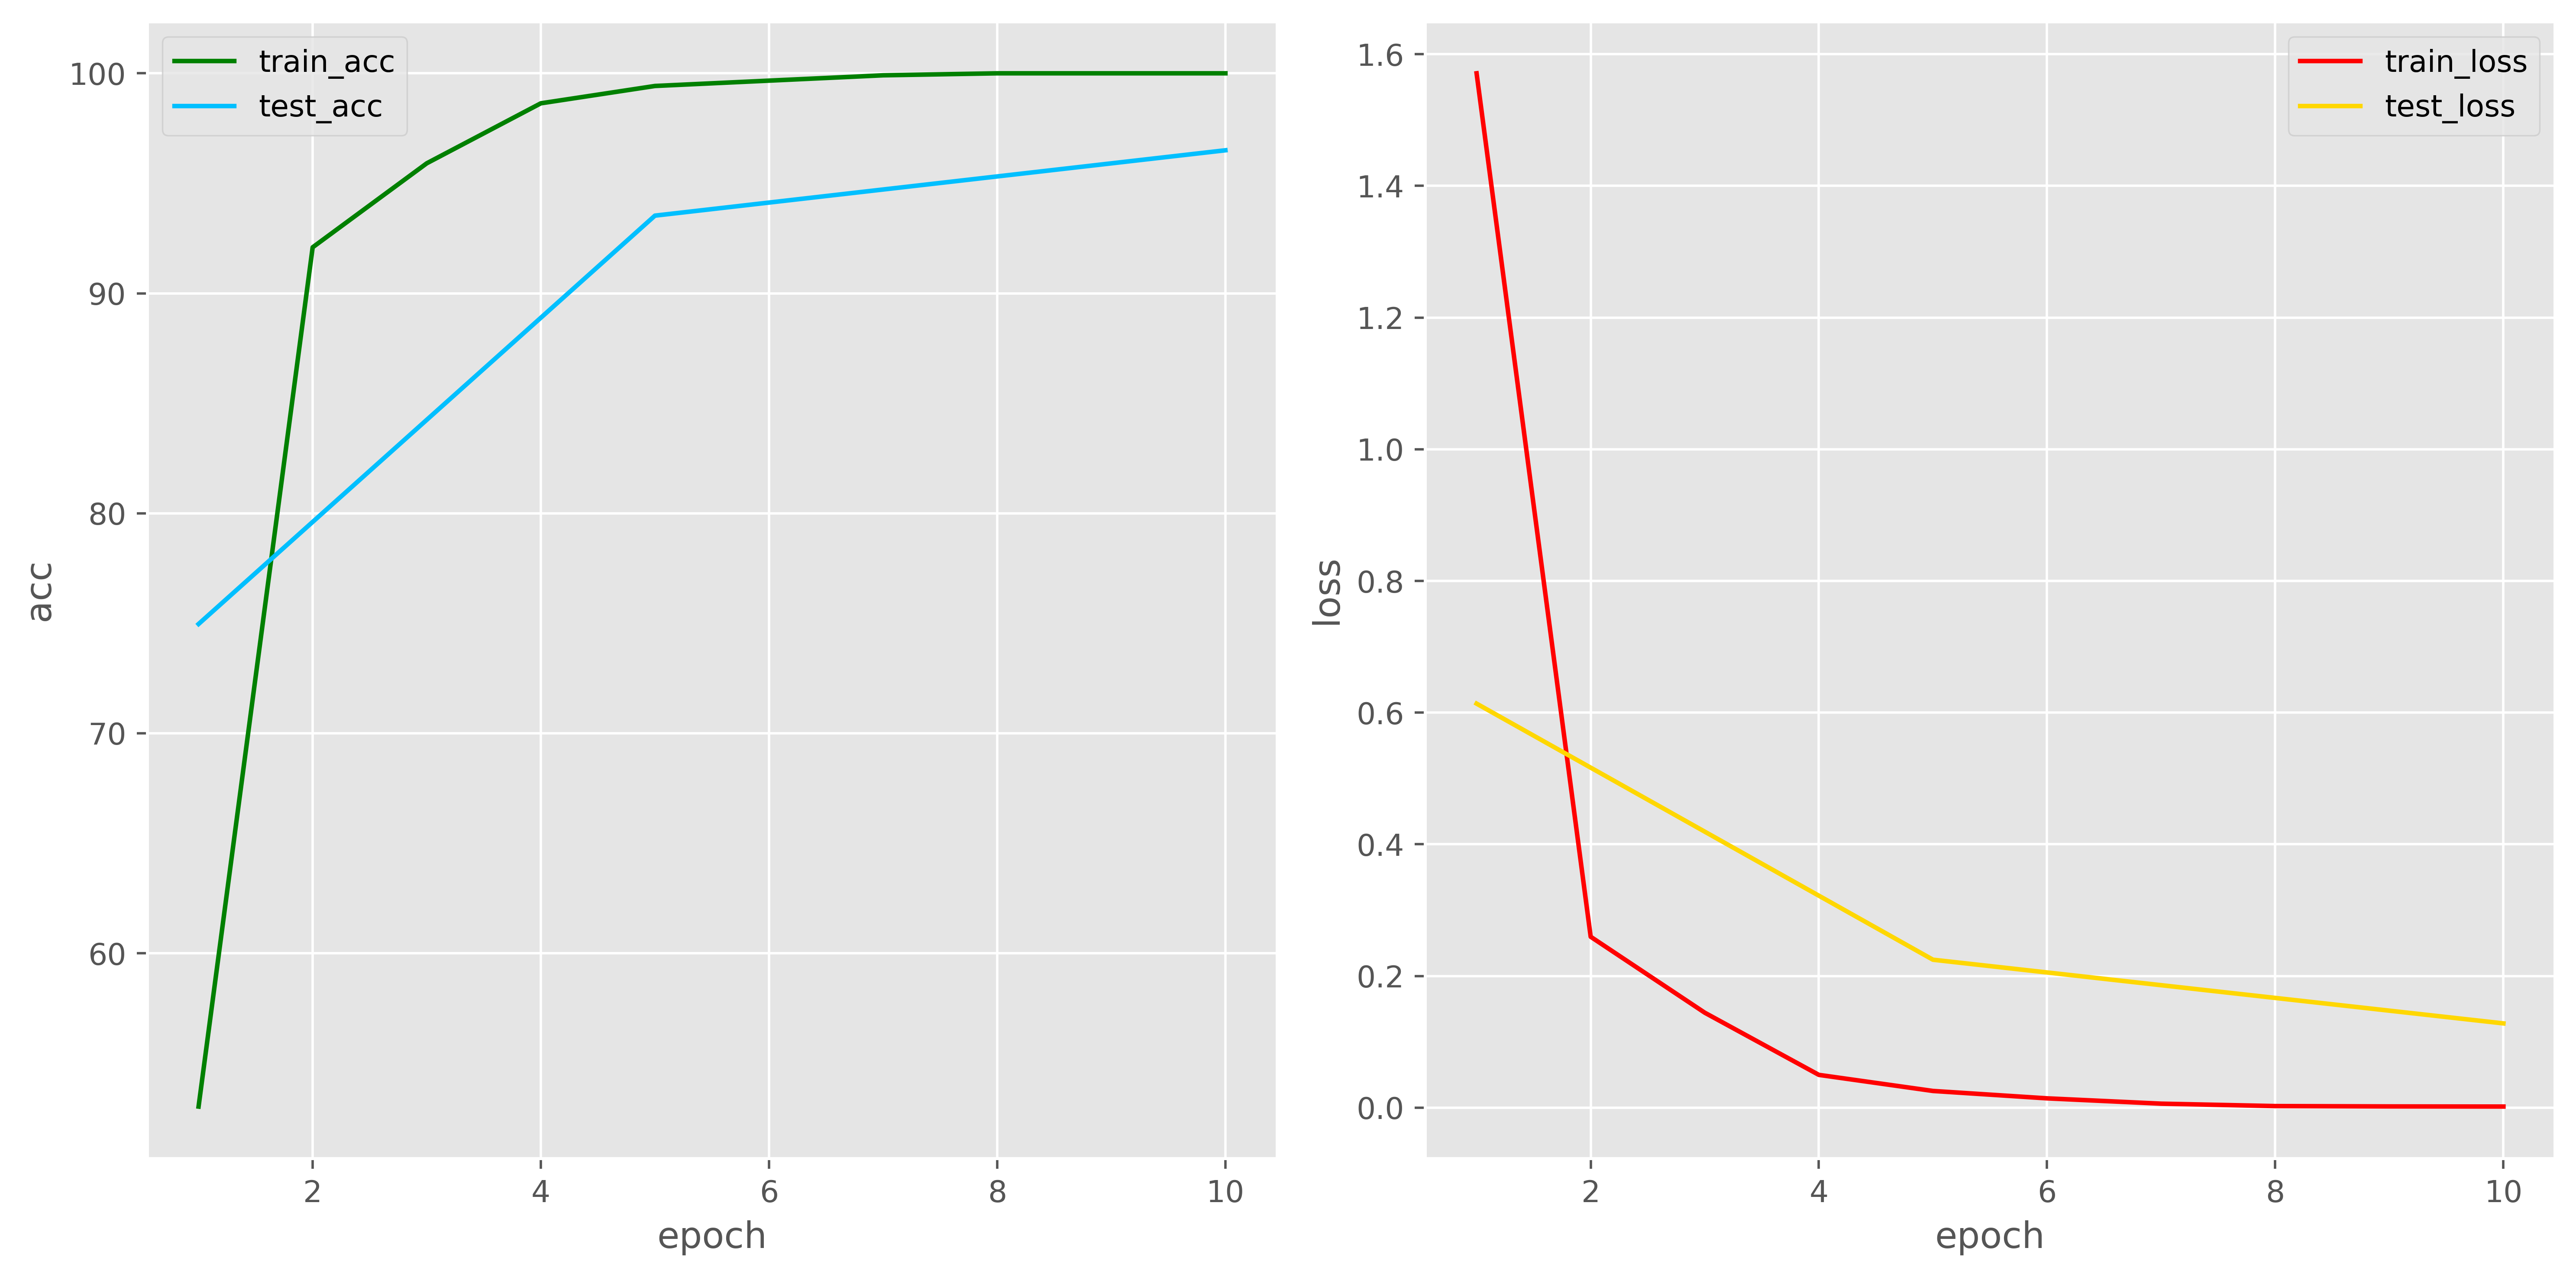

In [16]:
train_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_list]
train_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_list]
valida_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_acc_list]
valida_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_loss_list]

draw_acc_loss(train_acc_list, train_loss_list, valida_acc_list, valida_loss_list, valida_epochs_list, args.epoches, "content")

# SpectralCA

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1,
                 bias=False, use_norm=True, use_act=True, norm_type='group'):
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size,) * 3
        if isinstance(stride, int):
            stride = (stride,) * 3
        padding = tuple((k - 1) // 2 for k in kernel_size)

        layers = [nn.Conv3d(in_channels, out_channels, kernel_size, stride,
                            padding, groups=groups, bias=bias)]
        if use_norm:
            if norm_type == 'group':
                layers.append(nn.GroupNorm(num_groups=8, num_channels=out_channels))
            else:
                layers.append(nn.BatchNorm3d(out_channels))
        if use_act:
            layers.append(nn.SiLU())
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        assert dim % num_heads == 0, f"dim {dim} not divisible by num_heads {num_heads}"
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_spatial = nn.Linear(dim, dim)
        self.k_spectral = nn.Linear(dim, dim)
        self.v_spectral = nn.Linear(dim, dim)

        self.q_spectral = nn.Linear(dim, dim)
        self.k_spatial = nn.Linear(dim, dim)
        self.v_spatial = nn.Linear(dim, dim)

        self.proj_spatial = nn.Linear(dim, dim)
        self.proj_spectral = nn.Linear(dim, dim)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, spatial, spectral):
        # Get batch sizes and sequence lengths
        B_spatial, N_spatial, C = spatial.shape
        B_spectral, N_spectral, C = spectral.shape

        # Make sure batch sizes match
        assert B_spatial == B_spectral, f"Batch sizes must match: {B_spatial} vs {B_spectral}"
        B = B_spatial

        # Ensure dimension matches
        assert C == self.dim, f"Input dimension {C} doesn't match model dimension {self.dim}"

        # Define generalized attention function that handles different sequence lengths
        def attend(q, k, v):
            H = self.num_heads
            D = C // H

            # Get sequence length from the queries
            N_q = q.size(1)
            N_kv = k.size(1)

            # Reshape to multi-head attention format
            q = q.reshape(B, N_q, H, D).permute(0, 2, 1, 3)  # [B, H, N_q, D]
            k = k.reshape(B, N_kv, H, D).permute(0, 2, 1, 3)  # [B, H, N_kv, D]
            v = v.reshape(B, N_kv, H, D).permute(0, 2, 1, 3)  # [B, H, N_kv, D]

            # Compute attention scores
            attn = (q @ k.transpose(-2, -1)) * self.scale  # [B, H, N_q, N_kv]
            attn = F.softmax(attn, dim=-1)
            attn = self.attn_drop(attn)

            # Apply attention to values
            out = (attn @ v).transpose(1, 2).reshape(B, N_q, C)  # [B, N_q, C]
            return out

        # Spatial -> Spectral attention
        q_s = self.q_spatial(spatial)  # [B, N_spatial, C]
        k_sp = self.k_spectral(spectral)  # [B, N_spectral, C]
        v_sp = self.v_spectral(spectral)  # [B, N_spectral, C]
        sa = attend(q_s, k_sp, v_sp)  # [B, N_spatial, C]
        sa = self.proj_drop(self.proj_spatial(sa))

        # Spectral -> Spatial attention
        q_sp = self.q_spectral(spectral)  # [B, N_spectral, C]
        k_s = self.k_spatial(spatial)  # [B, N_spatial, C]
        v_s = self.v_spatial(spatial)  # [B, N_spatial, C]
        spa = attend(q_sp, k_s, v_s)  # [B, N_spectral, C]
        spa = self.proj_drop(self.proj_spectral(spa))

        return sa, spa

class SpectralCA(nn.Module):
    def __init__(self, in_channels, transformer_dim, patch_h=2, patch_w=2, patch_d=2,
                 num_heads=4, attn_dropout=0., dropout=0.1, ffn_dropout=0.1,
                 img_size=None, channel_depth=None, depth=None, mode=None):
        super().__init__()

        self.inner_dim = transformer_dim
        self.patch_h, self.patch_w, self.patch_d = patch_h, patch_w, patch_d

        self.spatial_conv = nn.Sequential(
            nn.Conv2d(in_channels, self.inner_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.inner_dim),
            nn.SiLU()
        )

        self.spectral_conv = nn.Sequential(
            nn.Conv3d(in_channels, self.inner_dim, kernel_size=3, padding=1),
            nn.BatchNorm3d(self.inner_dim),
            nn.SiLU()
        )

        self.cross_attn = CrossAttention(self.inner_dim, num_heads, attn_drop=attn_dropout, proj_drop=dropout)

        self.norm1_spatial = nn.LayerNorm(self.inner_dim)
        self.norm1_spectral = nn.LayerNorm(self.inner_dim)
        self.norm2_spatial = nn.LayerNorm(self.inner_dim)
        self.norm2_spectral = nn.LayerNorm(self.inner_dim)

        self.ffn_spatial = nn.Sequential(
            nn.Linear(self.inner_dim, self.inner_dim * 2),
            nn.SiLU(),
            nn.Dropout(ffn_dropout),
            nn.Linear(self.inner_dim * 2, self.inner_dim),
            nn.Dropout(ffn_dropout)
        )

        self.ffn_spectral = nn.Sequential(
            nn.Linear(self.inner_dim, self.inner_dim * 2),
            nn.SiLU(),
            nn.Dropout(ffn_dropout),
            nn.Linear(self.inner_dim * 2, self.inner_dim),
            nn.Dropout(ffn_dropout)
        )

        self.out_proj = nn.Conv3d(self.inner_dim * 2, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W, D = x.shape
        res = x

        # Spatial: mean across D -> 2D input
        spatial_input = x.mean(dim=4)  # [B, C, H, W]
        spatial = self.spatial_conv(spatial_input)  # [B, inner_dim, H, W]

        # Flatten spatial to sequence for attention
        spatial = spatial.permute(0, 2, 3, 1).reshape(B, H * W, self.inner_dim)  # [B, H*W, inner_dim]

        # Spectral: keep full 3D
        spectral = self.spectral_conv(x)  # [B, inner_dim, H, W, D]
        # Flatten spectral to sequence for attention
        spectral = spectral.reshape(B, self.inner_dim, H * W * D).transpose(1, 2)  # [B, H*W*D, inner_dim]

        # Apply normalization before attention
        spatial_norm = self.norm1_spatial(spatial)  # [B, H*W, inner_dim]
        spectral_norm = self.norm1_spectral(spectral)  # [B, H*W*D, inner_dim]

        # Cross attention between spatial and spectral
        sa, spa = self.cross_attn(spatial_norm, spectral_norm)

        # Skip connection + norm
        spatial = spatial + sa  # [B, H*W, inner_dim]
        spectral = spectral + spa  # [B, H*W*D, inner_dim]

        # Second normalization
        spatial_norm2 = self.norm2_spatial(spatial)
        spectral_norm2 = self.norm2_spectral(spectral)

        # FFN
        spatial = spatial + self.ffn_spatial(spatial_norm2)  # [B, H*W, inner_dim]
        spectral = spectral + self.ffn_spectral(spectral_norm2)  # [B, H*W*D, inner_dim]

        # Reshape back
        spatial = spatial.reshape(B, H, W, self.inner_dim).permute(0, 3, 1, 2)  # [B, inner_dim, H, W]
        spectral = spectral.transpose(1, 2).reshape(B, self.inner_dim, H, W, D)  # [B, inner_dim, H, W, D]

        # Concatenate spatial and spectral features
        # Expand spatial to match 3D dimensions
        spatial_expanded = spatial.unsqueeze(-1).expand(-1, -1, -1, -1, D)  # [B, inner_dim, H, W, D]
        combined = torch.cat([spatial_expanded, spectral], dim=1)  # [B, 2*inner_dim, H, W, D]

        # Project back to original channel dimensions
        out = self.out_proj(combined)  # [B, C, H, W, D]

        # Ensure output has same shape as residual
        if out.shape != res.shape:
            out = F.interpolate(out, size=res.shape[2:], mode="trilinear", align_corners=False)

        # Residual connection
        return out + res

class SpectralCA_MDvT(nn.Module):
    def __init__(self, image_size, channels, num_classes, dim=64, kernels=[3, 3, 3], strides=[2, 2, 2],
                 heads=[2, 4, 4], depth=[2, 4, 6], pool='cls', dropout=0.1, emb_dropout=0.1, scale_dim=4, mode="ViT"):
        super().__init__()
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim
        self.heads = heads
        ##### Stage 1 #######
        # n is spectral dimention
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=dim, kernel_size=kernels[0], stride=strides[0], padding=1),
            nn.BatchNorm3d(dim),
            nn.ReLU(inplace=True),
        )
        self.stage1_transformer = nn.Sequential(
            SpectralCA(in_channels=dim, transformer_dim=96, img_size=(image_size + 1) // 2,
                           channel_depth=(channels + 1) // 2,
                           depth=depth[0], num_heads=heads[0], mode=mode),
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = 2
        channels = (channels + 1) // 2
        image_size = (image_size + 1) // 2
        dim = scale * dim
        self.conv2 = nn.Sequential(
            nn.Conv3d(in_channels, dim, kernels[1], strides[1], 1),
            nn.BatchNorm3d(dim),
            nn.ReLU(inplace=True),
        )
        self.stage2_transformer = nn.Sequential(
            SpectralCA(in_channels=dim, transformer_dim=120, img_size=(image_size + 1) // 2,
                           channel_depth=(channels + 1) // 2, depth=depth[1], num_heads=heads[1], mode=mode),
        )

        ##### Stage 3 #######
        in_channels = dim
        # //((heads[1]//heads[0]))
        scale = 2
        channels = (channels + 1) // 2
        image_size = (image_size + 1) // 2
        dim = (scale * dim)
        self.conv3 = InvertedResidual(in_channels, dim, 2, 1, 6)
        self.stage3_conv_embed = nn.Sequential(
            Rearrange('b c h w n-> b (h w n) c', h=(image_size + 1) // 2, w=(image_size + 1) // 2),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=(image_size + 1) // 2, depth=depth[2],
                        heads=heads[2], channel_depth=(channels + 1) // 2, dim_head=self.dim,
                        dropout=dropout, last_stage=True, mode=mode),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        conv1 = self.conv1(img)
        xs_trans1 = self.stage1_transformer(conv1)

        conv2 = self.conv2(xs_trans1)
        xs_trans2 = self.stage2_transformer(conv2)

        conv3 = self.conv3(xs_trans2)
        xs_conv3 = self.stage3_conv_embed(conv3)
        b, n, _ = xs_conv3.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs_cat = torch.cat((cls_tokens, xs_conv3), dim=1)
        xs_drop = self.dropout_large(xs_cat)
        xs_trans3 = self.stage3_transformer(xs_drop)
        xs = xs_trans3.mean(dim=1) if self.pool == 'mean' else xs_trans3[:, 0]

        xs = self.mlp_head(xs)
        return xs

# Execution


In [18]:
print("---------------------dataset={0}---model={1}----mode={2}------------------".format(args.dataset, args.model, args.mode))

label_train_loader = Data.DataLoader(Label_train, batch_size=32, shuffle=True)
label_test_loader = Data.DataLoader(Label_test, batch_size=32, shuffle=True)

# img = torch.ones([1, 3, 224, 224]).to(device)
# ----------------------------------------------------------------------
model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).cuda()

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches // 10, gamma=args.gamma)
tic = time.time()
# include train and test
if args.flag_test == 'train and test':
    tic = time.time()

    train_acc_list = []
    valida_acc_list = []
    train_loss_list = []
    valida_loss_list = []

    valida_epochs_list = []

    for epoch in range(args.epoches):

        # train modeltrain
        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        scheduler.step()

        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
              .format(epoch + 1, train_obj, train_acc))

        if ((epoch + 1) % args.test_freq == 0) or (epoch == 0):
            model.eval()
            with torch.no_grad():
                test_acc2, test_obj2, tar_v, pre_v = test_epoch(model, label_test_loader, criterion, optimizer)
                OA2, AA_mean2, Kappa2, AA2, matrix, classification = output_metric(tar_v, pre_v)
                print("Epoch: {:03d} test_loss: {:.4f} test_acc: {:.4f} OA2: {:.4f} AA_mean2: {:.4f} Kappa2: {:.4f}"
                      .format(epoch + 1, test_obj2, test_acc2, OA2, AA_mean2, Kappa2))

                valida_acc_list.append(test_acc2)
                valida_loss_list.append(test_obj2)

                valida_epochs_list.append(epoch + 1)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_obj)

    toc = time.time()
    torch.save(model.state_dict(), model_path)
    print("Running Time: {:.2f}".format(toc - tic))
    print("**************************************************")
    print("Final result:")
    print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
    print(AA2)
    print()

    with open(file_name, 'w') as x_file:
        x_file.write('{:.4f} Test loss(%)'.format(test_obj2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('{:.4f} Test accuracy (%)'.format(test_acc2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} Kappa accuracy (%)'.format(Kappa2))
        x_file.write('\n')
        x_file.write('{:.4f} Overall accuracy (%)'.format(OA2))
        x_file.write('\n')
        x_file.write('{:.4f} Average accuracy (%)'.format(AA_mean2))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{} classification (%)'.format(classification))
        x_file.write('\n')
        x_file.write('{} matrix (%)'.format(matrix))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} time (%)'.format(toc - tic))
    print("-------------txt finish-------------------")
else :
    print("Shape of out :")  # [B, num_classes]

---------------------dataset=HongHu15---model=MDvT----mode=ViT------------------
Trainable Parameters: 6.628M
100%|██████████| 104/104 [00:25<00:00,  4.10it/s]
Epoch: 001 train_loss: 2.1970 train_acc: 30.8182
100%|██████████| 799/799 [00:49<00:00, 16.02it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch: 001 test_loss: 1.9611 test_acc: 27.1400 OA2: 0.2714 AA_mean2: 0.3653 Kappa2: 0.2130
100%|██████████| 104/104 [00:22<00:00,  4.66it/s]
Epoch: 002 train_loss: 0.7727 train_acc: 75.1818
100%|██████████| 104/104 [00:21<00:00,  4.73it/s]
Epoch: 003 train_loss: 0.3818 train_acc: 88.1515
100%|██████████| 104/104 [00:22<00:00,  4.73it/s]
Epoch: 004 train_loss: 0.1805 train_acc: 94.6364
100%|██████████| 104/104 [00:22<00:00,  4.71it/s]
Epoch: 005 train_loss: 0.0881 train_acc: 97.8182
100%|██████████| 799/799 [00:50<00:00, 15.94it/s]
Epoch: 005 test_loss: 0.4583 test_acc: 85.6198 OA2: 0.8562 AA_mean2: 0.8731 Kappa2: 0.8195
100%|██████████| 104/104 [00:22<00:00,  4.71it/s]
Epoch: 006 train_loss: 0.0446 train_acc: 98.9091
100%|██████████| 104/104 [00:22<00:00,  4.71it/s]
Epoch: 007 train_loss: 0.0166 train_acc: 99.6970
100%|██████████| 104/104 [00:22<00:00,  4.72it/s]
Epoch: 008 train_loss: 0.0324 train_acc: 99.2424
100%|██████████| 104/104 [00:22<00:00,  4.72it/s]
Epoch: 009 train_loss: 0

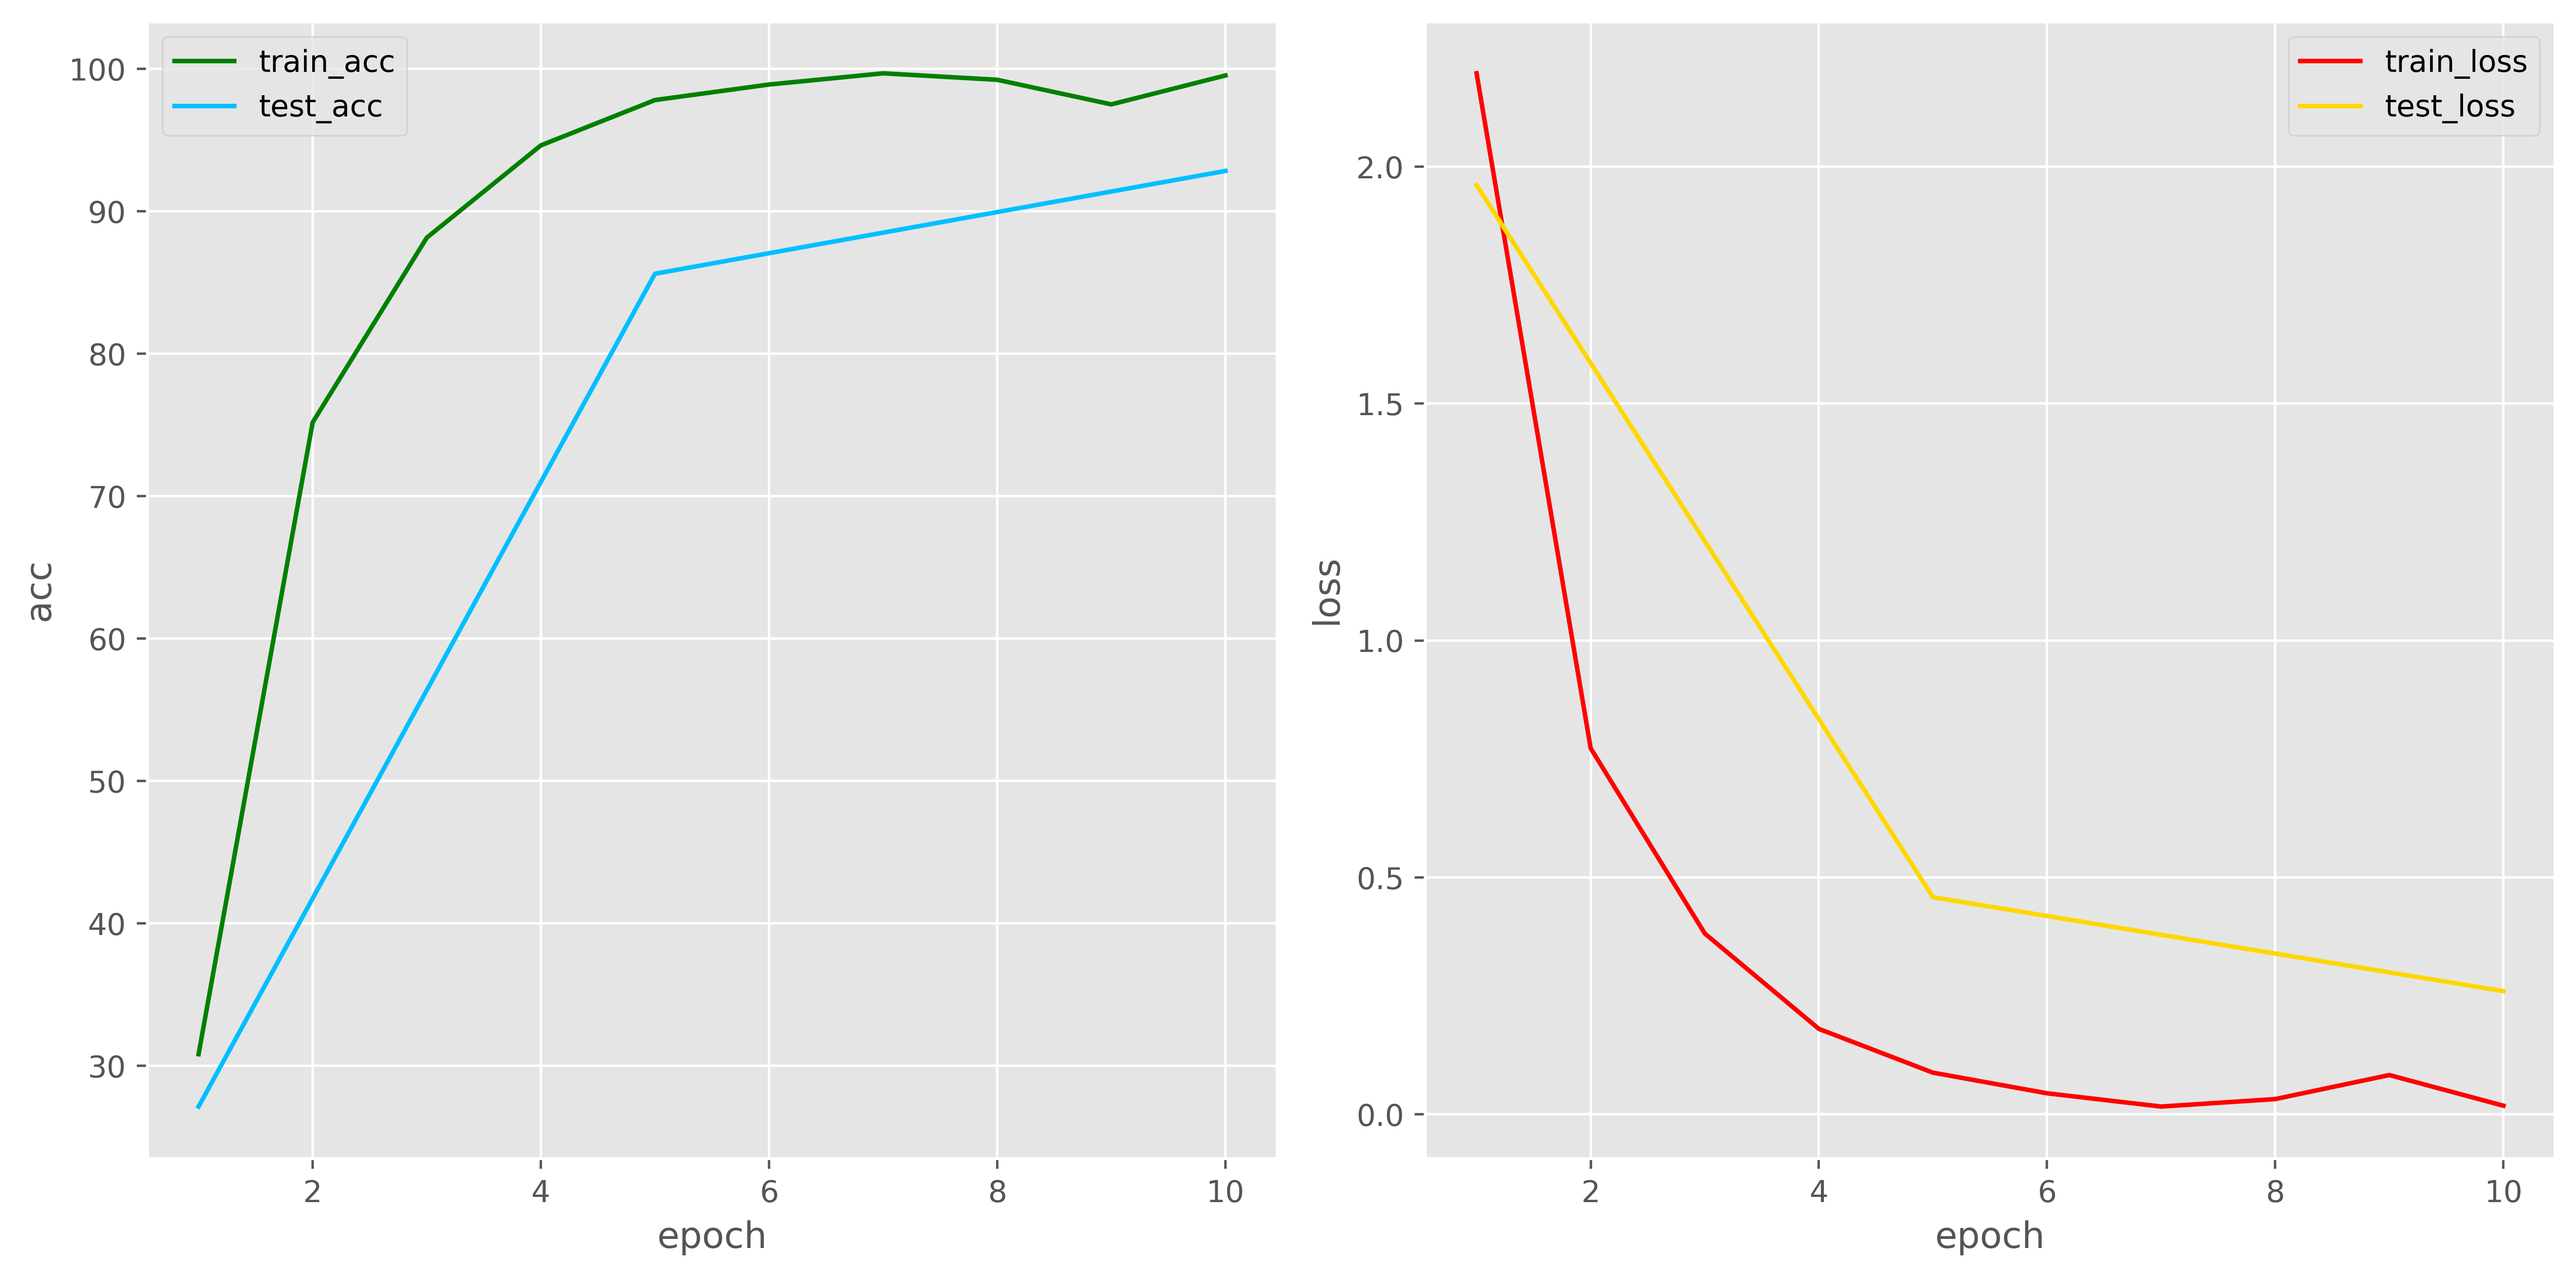

In [19]:
train_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_list]
train_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_list]
valida_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_acc_list]
valida_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_loss_list]

draw_acc_loss(train_acc_list, train_loss_list, valida_acc_list, valida_loss_list, valida_epochs_list, args.epoches, "content")

# SSL v1

In [22]:
model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).to(device)
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load("/content/SpectralCA-base.pt"))

<All keys matched successfully>

In [23]:
test300_meta = gdal.Open("/content/drive/MyDrive/WHU-Hi-HongHu/Training samples and test samples/Test300.tif").ReadAsArray()

test300_coords = np.argwhere(test300_meta > 0)  # (N, 2)
train_coord_set = set(map(tuple, total_train))
filtered_unlabeled = [tuple(coord) for coord in test300_coords if tuple(coord) not in train_coord_set]
filtered_unlabeled = np.array(filtered_unlabeled)

import random

subset_size = 5000  # tune this as RAM allows
subset_coords = random.sample(list(map(tuple, filtered_unlabeled)), subset_size)
filtered_unlabeled = np.array(subset_coords)

print(f"Pseudo-label candidate count: {len(filtered_unlabeled)}")

def extract_in_batches(coords, batch_size=10000):
    all_x = []
    for i in range(0, len(coords), batch_size):
        batch = coords[i:i+batch_size]
        x_batch = train_and_test_data(mirror_image, data_hsi.shape[2], batch, patch=args.patches)
        all_x.append(x_batch)
    return np.concatenate(all_x, axis=0)

x_unlabeled_band = extract_in_batches(filtered_unlabeled, batch_size=5000)

x_unlabeled = torch.from_numpy(x_unlabeled_band).type(torch.FloatTensor).unsqueeze(1).to(device)

unlabeled_dataset = Data.TensorDataset(x_unlabeled.cpu())
unlabeled_loader = Data.DataLoader(unlabeled_dataset, batch_size=128, shuffle=False)

model.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for (xb,) in unlabeled_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = F.softmax(logits, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        all_preds.append(preds.cpu())
        all_probs.append(max_probs.cpu())

y_unlabeled_pred = torch.cat(all_preds)
y_unlabeled_conf = torch.cat(all_probs)

confident_mask = y_unlabeled_conf > 0.9
x_confident = x_unlabeled[confident_mask]
y_confident = y_unlabeled_pred[confident_mask]

Label_proxy = Data.TensorDataset(x_confident.cpu(), y_confident.cpu())
Label_combined = Data.ConcatDataset([Label_train, Label_proxy])

Pseudo-label candidate count: 5000
100%|██████████| 5000/5000 [00:00<00:00, 5995.19it/s]
x_train shape = (5000, 15, 15, 100), type = float64


In [24]:
print("---------------------dataset={0}---model={1}----mode={2}------------------".format(args.dataset, args.model, args.mode))

label_train_loader = Data.DataLoader(Label_combined, batch_size=32, shuffle=True)
label_test_loader = Data.DataLoader(Label_test, batch_size=32, shuffle=True)

# img = torch.ones([1, 3, 224, 224]).to(device)
# ----------------------------------------------------------------------
model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).cuda()

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches // 10, gamma=args.gamma)
tic = time.time()
# include train and test
if args.flag_test == 'train and test':
    tic = time.time()

    train_acc_list = []
    valida_acc_list = []
    train_loss_list = []
    valida_loss_list = []

    valida_epochs_list = []

    for epoch in range(args.epoches):

        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        scheduler.step()

        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
              .format(epoch + 1, train_obj, train_acc))

        if ((epoch + 1) % args.test_freq == 0) or (epoch == 0):
            model.eval()
            with torch.no_grad():
                test_acc2, test_obj2, tar_v, pre_v = test_epoch(model, label_test_loader, criterion, optimizer)
                OA2, AA_mean2, Kappa2, AA2, matrix, classification = output_metric(tar_v, pre_v)
                print("Epoch: {:03d} test_loss: {:.4f} test_acc: {:.4f} OA2: {:.4f} AA_mean2: {:.4f} Kappa2: {:.4f}"
                      .format(epoch + 1, test_obj2, test_acc2, OA2, AA_mean2, Kappa2))

                valida_acc_list.append(test_acc2)
                valida_loss_list.append(test_obj2)

                valida_epochs_list.append(epoch + 1)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_obj)

    toc = time.time()
    torch.save(model.state_dict(), model_path + "_ssl")
    print("Running Time: {:.2f}".format(toc - tic))
    print("**************************************************")
    print("Final result:")
    print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
    print(AA2)
    print()

    with open(file_name, 'w') as x_file:
        x_file.write('{:.4f} Test loss(%)'.format(test_obj2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('{:.4f} Test accuracy (%)'.format(test_acc2.cpu().numpy()))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} Kappa accuracy (%)'.format(Kappa2))
        x_file.write('\n')
        x_file.write('{:.4f} Overall accuracy (%)'.format(OA2))
        x_file.write('\n')
        x_file.write('{:.4f} Average accuracy (%)'.format(AA_mean2))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{} classification (%)'.format(classification))
        x_file.write('\n')
        x_file.write('{} matrix (%)'.format(matrix))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write('{:.4f} time (%)'.format(toc - tic))
    print("-------------txt finish-------------------")
else :
    print("Shape of out :")  # [B, num_classes]

---------------------dataset=HongHu15---model=MDvT----mode=ViT------------------
Trainable Parameters: 6.628M
100%|██████████| 253/253 [00:56<00:00,  4.45it/s]
Epoch: 001 train_loss: 1.1393 train_acc: 66.0186
100%|██████████| 799/799 [00:49<00:00, 16.06it/s]
Epoch: 001 test_loss: 0.6545 test_acc: 78.8446 OA2: 0.7884 AA_mean2: 0.7459 Kappa2: 0.7342
100%|██████████| 253/253 [00:53<00:00,  4.69it/s]
Epoch: 002 train_loss: 0.2039 train_acc: 93.8947
100%|██████████| 253/253 [00:53<00:00,  4.70it/s]
Epoch: 003 train_loss: 0.0877 train_acc: 97.2879
100%|██████████| 253/253 [00:53<00:00,  4.70it/s]
Epoch: 004 train_loss: 0.0488 train_acc: 98.5015
100%|██████████| 253/253 [00:53<00:00,  4.69it/s]
Epoch: 005 train_loss: 0.0423 train_acc: 98.6997
100%|██████████| 799/799 [00:49<00:00, 16.02it/s]
Epoch: 005 test_loss: 0.2601 test_acc: 92.0819 OA2: 0.9208 AA_mean2: 0.9140 Kappa2: 0.8998
100%|██████████| 253/253 [00:53<00:00,  4.70it/s]
Epoch: 006 train_loss: 0.0301 train_acc: 99.2074
100%|█████████

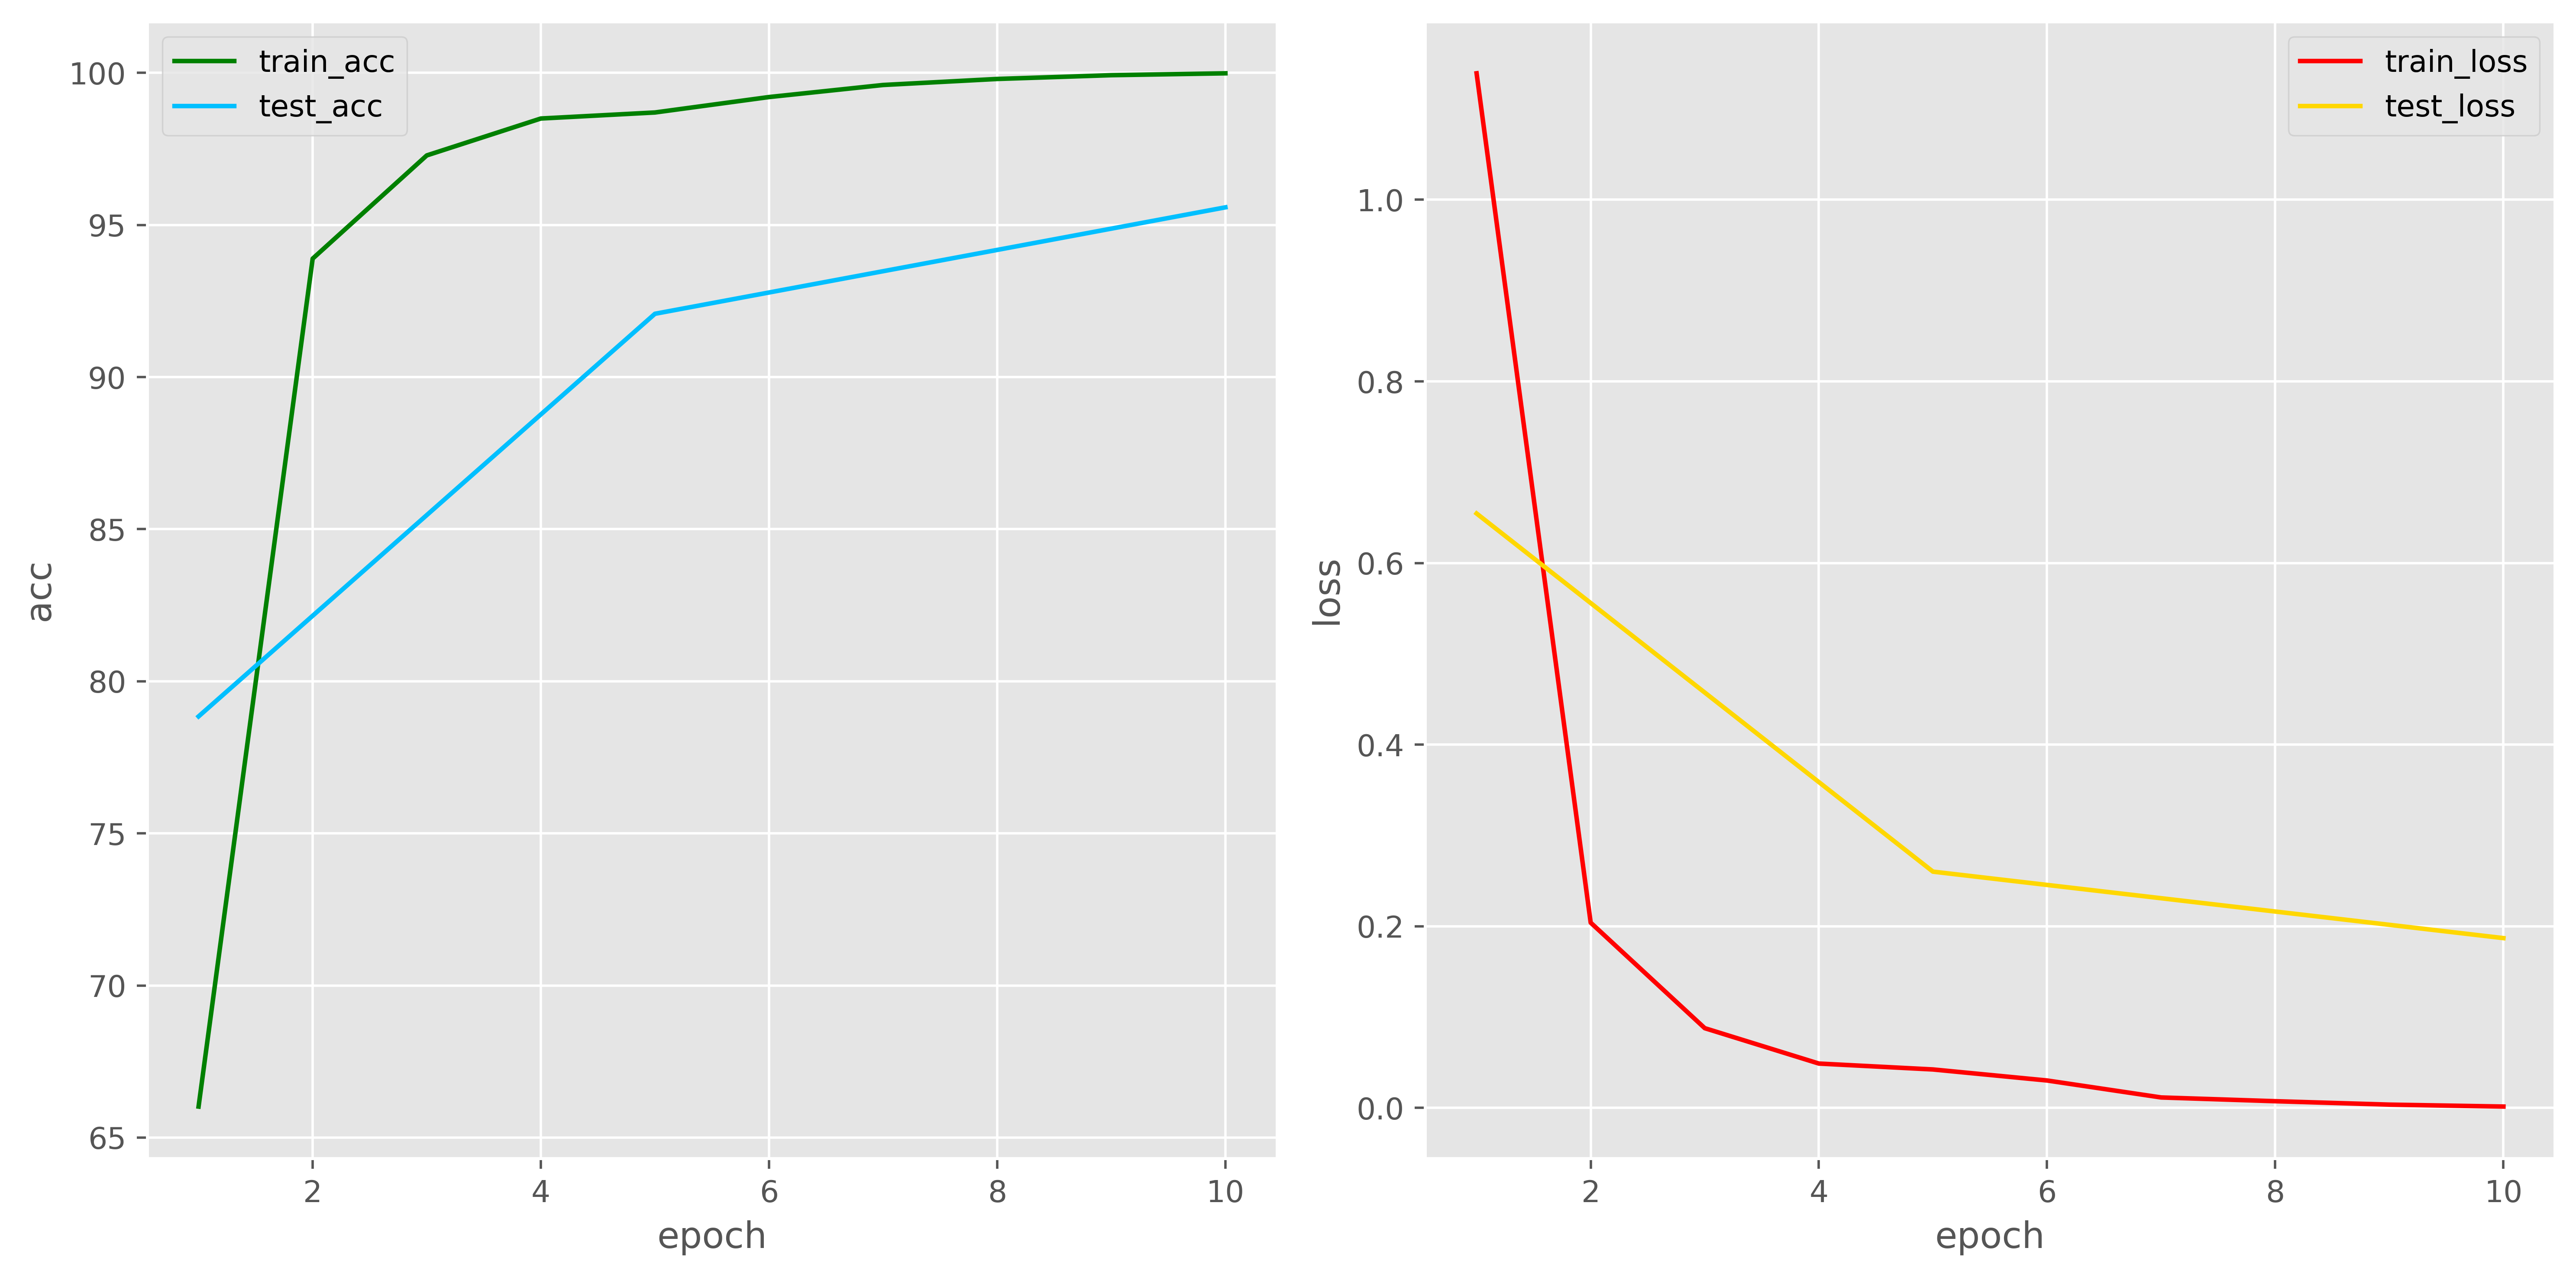

In [25]:
train_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_list]
train_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_list]
valida_acc_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_acc_list]
valida_loss_list = [x.cpu().item() if torch.is_tensor(x) else x for x in valida_loss_list]

draw_acc_loss(train_acc_list, train_loss_list, valida_acc_list, valida_loss_list, valida_epochs_list, args.epoches, "content")

# SSL v2

In [26]:
# pseudo_iterations = 2
# pseudo_epochs = 5
# subset_sizes = [2000, 2000]
# confidence_thresholds = [0.90, 0.92]

In [27]:
# model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).to(device)
# # model.load_state_dict(torch.load(model_path))
# model.load_state_dict(torch.load("/content/SpectralCA-base.pt"))

In [28]:
# test300_meta = gdal.Open("/content/drive/MyDrive/WHU-Hi-HongHu/Training samples and test samples/Test300.tif").ReadAsArray()

# test300_coords = np.argwhere(test300_meta > 0)  # (N, 2)
# train_coord_set = set(map(tuple, total_train))
# filtered_unlabeled = [tuple(coord) for coord in test300_coords if tuple(coord) not in train_coord_set]
# filtered_unlabeled = np.array(filtered_unlabeled)

# def extract_in_batches(coords, batch_size=10000):
#     all_x = []
#     for i in range(0, len(coords), batch_size):
#         batch = coords[i:i+batch_size]
#         x_batch = train_and_test_data(mirror_image, data_hsi.shape[2], batch, patch=args.patches)
#         all_x.append(x_batch)
#     return np.concatenate(all_x, axis=0)


# Label_combined = Label_train

In [29]:
# print("Starting iterative pseudo-labeling...")

# tic = time.time()

# for iter_idx in range(pseudo_iterations):
#     print(f"\n=== Iteration {iter_idx + 1} ===")

#     # --- фільтруємо unlabeled дані ---
#     subset_size = subset_sizes[iter_idx]
#     threshold = confidence_thresholds[iter_idx]

#     subset_coords = random.sample(list(map(tuple, filtered_unlabeled)), subset_size)
#     current_coords = np.array(subset_coords)

#     x_unlabeled_band = extract_in_batches(current_coords, batch_size=5000)
#     x_unlabeled = torch.from_numpy(x_unlabeled_band).type(torch.FloatTensor).unsqueeze(1).to(device)

#     unlabeled_dataset = Data.TensorDataset(x_unlabeled.cpu())
#     unlabeled_loader = Data.DataLoader(unlabeled_dataset, batch_size=128, shuffle=False)

#     # --- псевдо-розмітка ---
#     model.eval()
#     all_preds, all_probs = [], []

#     with torch.no_grad():
#         for (xb,) in unlabeled_loader:
#             xb = xb.to(device)
#             logits = model(xb)
#             probs = F.softmax(logits, dim=1)
#             max_probs, preds = torch.max(probs, dim=1)
#             all_preds.append(preds.cpu())
#             all_probs.append(max_probs.cpu())

#     y_unlabeled_pred = torch.cat(all_preds)
#     y_unlabeled_conf = torch.cat(all_probs)

#     confident_mask = y_unlabeled_conf > threshold
#     x_confident = x_unlabeled[confident_mask]
#     y_confident = y_unlabeled_pred[confident_mask]

#     print(f"Selected {x_confident.shape[0]} confident pseudo-labeled samples (threshold={threshold})")

#     if x_confident.shape[0] == 0:
#         print("Warning: No confident samples selected, stopping early.")
#         break

#     Label_proxy = Data.TensorDataset(x_confident.cpu(), y_confident.cpu())
#     Label_combined = Data.ConcatDataset([Label_combined, Label_proxy])

#     # --- ініціалізація нової моделі перед донавчанням ---
#     # model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).cuda()

#     parameters = filter(lambda p: p.requires_grad, model.parameters())
#     parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
#     print('Trainable Parameters: %.3fM' % parameters)

#     criterion = nn.CrossEntropyLoss().cuda()
#     optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches // 10, gamma=args.gamma)

#     label_train_loader = Data.DataLoader(Label_combined, batch_size=32, shuffle=True)
#     label_test_loader = Data.DataLoader(Label_test, batch_size=32, shuffle=False)

#     # --- донавчання ---
#     for epoch in range(pseudo_epochs):
#         model.train()
#         train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
#         scheduler.step()

#         print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
#               .format(epoch + 1, train_obj, train_acc))

#         if ((epoch + 1) % args.test_freq == 0):
#             model.eval()
#             with torch.no_grad():
#                 test_acc2, test_obj2, tar_v, pre_v = test_epoch(model, label_test_loader, criterion, optimizer)
#                 OA2, AA_mean2, Kappa2, AA2, matrix, classification = output_metric(tar_v, pre_v)
#                 print("Epoch: {:03d} test_loss: {:.4f} test_acc: {:.4f} OA2: {:.4f} AA_mean2: {:.4f} Kappa2: {:.4f}"
#                       .format(epoch + 1, test_obj2, test_acc2, OA2, AA_mean2, Kappa2))

# toc = time.time()

In [30]:
# torch.save(model.state_dict(), model_path + "_ssl")

# print("Running Time: {:.2f}".format(toc - tic))
# print("**************************************************")
# print("Final result:")
# print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
# print(AA2)
# print()

# with open(file_name, 'w') as x_file:
#     x_file.write('{:.4f} Test loss(%)'.format(test_obj2.cpu().numpy()))
#     x_file.write('\n')
#     x_file.write('{:.4f} Test accuracy (%)'.format(test_acc2.cpu().numpy()))
#     x_file.write('\n')
#     x_file.write('\n')
#     x_file.write('{:.4f} Kappa accuracy (%)'.format(Kappa2))
#     x_file.write('\n')
#     x_file.write('{:.4f} Overall accuracy (%)'.format(OA2))
#     x_file.write('\n')
#     x_file.write('{:.4f} Average accuracy (%)'.format(AA_mean2))
#     x_file.write('\n')
#     x_file.write('\n')
#     x_file.write('{} classification (%)'.format(classification))
#     x_file.write('\n')
#     x_file.write('{} matrix (%)'.format(matrix))
#     x_file.write('\n')
#     x_file.write('\n')
#     x_file.write('{:.4f} time (%)'.format(toc - tic))
# print("-------------txt finish-------------------")

# Model Analysis

In [34]:
!pip install torchinfo

from torchinfo import summary

In [40]:
model = SpectralCA_MDvT(image_size=args.patches, channels=band, num_classes=args.num_classes, mode=args.mode).to(device)
model.load_state_dict(torch.load("/content/SpectralCA-base.pt", map_location=torch.device('cpu')))

summary(model)

Layer (type:depth-idx)                                       Param #
SpectralCA_MDvT                                              256
├─Sequential: 1-1                                            --
│    └─Conv3d: 2-1                                           1,792
│    └─BatchNorm3d: 2-2                                      128
│    └─ReLU: 2-3                                             --
├─Sequential: 1-2                                            --
│    └─SpectralCA: 2-4                                       --
│    │    └─Sequential: 3-1                                  55,584
│    │    └─Sequential: 3-2                                  166,176
│    │    └─CrossAttention: 3-3                              74,496
│    │    └─LayerNorm: 3-4                                   192
│    │    └─LayerNorm: 3-5                                   192
│    │    └─LayerNorm: 3-6                                   192
│    │    └─LayerNorm: 3-7                                   192
│    │    └─S